## Gaussian beams

for a gaussian beam the waist is defined as follow

$$ w(z) = w_0 \sqrt{1+\left( \frac{\lambda z}{\pi w_0^2} \right)^2} = w_0 \sqrt{1+\left( \frac{z}{z_R} \right)^2} $$

while the rayleigh range can be expressed as:

$$ z_R = \frac{\pi w_0^2}{\lambda} $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_rayleigh_range(w0, wavelenght):
    return np.pi*w0**2/wavelenght

def get_wz(z, w0, wavelenght):
    return w0*np.sqrt(1+(z/get_rayleigh_range(w0, wavelenght))**2)

def intensity_profile_z(z, x, w0, wavelenght):
    return np.exp(-x**2/(2*get_wz(z, w0, wavelenght)**2))/(np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))

def inverse_intensity_profile_z(z, I, w0, wavelenght):
    return get_wz(z, w0, wavelenght)*np.sqrt(2*np.log(1/(I*np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))))

In [3]:
waist_0 = 5 # [um]
wavelenght = 840 * 10**-3 # [um]

z_R = get_rayleigh_range(waist_0, wavelenght)

zs = np.linspace(-2*z_R, 2*z_R, 10000)
wzs = get_wz(zs, waist_0, wavelenght)

x_fixedIs = []
for x in np.linspace(0, waist_0, 10):
    I0 = intensity_profile_z(0, x, waist_0, wavelenght)
    x_fixedIs.append(inverse_intensity_profile_z(zs, I0, waist_0, wavelenght))

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_18978/3525387039.py:14: RuntimeWarning: invalid value encountered in sqrt
  return get_wz(z, w0, wavelenght)*np.sqrt(2*np.log(1/(I*np.sqrt(2*np.pi*get_wz(z, w0, wavelenght)**2))))


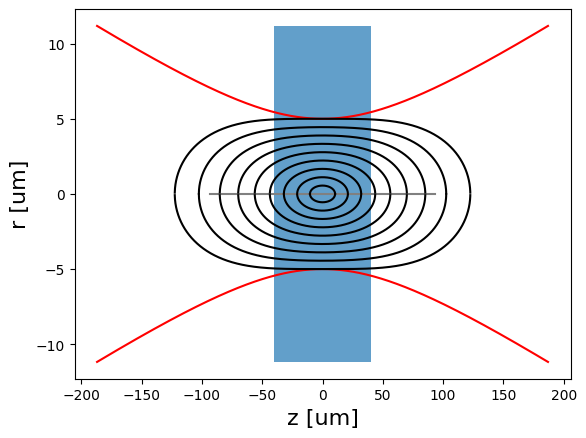

In [4]:
M = max(wzs)
plt.fill_between([-40, 40],[M, M],[-M, -M], alpha =0.7)

plt.plot(zs, wzs, c="r")
plt.plot(zs, -wzs, c="r")
plt.plot([-z_R,z_R],[0,0], c="gray")
for x_fixedI in x_fixedIs:
    plt.plot(zs, x_fixedI, c="black")
    plt.plot(zs, -x_fixedI, c="black")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()

## trap depth

the

$$ U_{dip}(z, r) = \frac{3 \pi c^2}{2 \omega_0^3} \frac{\Gamma}{\Delta} I(z, r) $$

$$ I(z, r) = \frac{2P}{\pi w(z)^2} e^{\frac{-2 r^2}{w(z)^2}} $$

so

$$ U_{dip}(z, r) =  \frac{3 \pi c^2}{2 \omega_0^3} \frac{\Gamma}{\Delta} \frac{2P}{\pi w(z)^2} e^{\frac{-2 r^2}{w(z)^2}} = \frac{3 c^2  P}{\omega_0^3 w(z)^2 }  \frac{\Gamma}{\Delta}  e^{-\frac{2 r^2}{w(z)^2} } $$

where 

$$ \Gamma = \frac{e^2 \omega_0^2}{6 \pi \epsilon_0 m_e c^3} $$

In [5]:
import scipy.constants as scc

class dipolar_trap:
    def __init__(self, power, waist_0, Temperature=1e-5) -> None:
        self.waist_0 = waist_0
        self.power = power
        self.rubidium_mass = 1.41810133E-25 # kg
        self.Delta = -2*np.pi*27e12
        self.T = Temperature # [K]
        self.omega_0 = 2*np.pi*377e12
        self.Gamma = scc.e**2*self.omega_0**2/(6*np.pi*scc.epsilon_0*scc.m_e*scc.c**3)
        self.alpha = 3*scc.c**2 * self.Gamma * self.power / (self.omega_0**3 * abs(self.Delta))
        self.wavelenght = 840e-9
        self.z_R = np.pi*waist_0**2/self.wavelenght
        self.var_r_0 = scc.Boltzmann * self.T * self.waist_0**4 / (4*self.alpha)
        self.var_z_0 = self.var_r_0 * np.pi**2 * self.waist_0**2 / self.wavelenght**2
        pass

    def get_wz(self, z):
        return self.waist_0*np.sqrt(1+(z/self.z_R)**2)

    def var_r(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_r_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2
    
    def var_z(self, t):
        """ 
        returns the variance of the density distribution in a time t.
        """
        return self.var_z_0 + (scc.Boltzmann*self.T/self.rubidium_mass) * t**2

    def I(self, z, r):
        return 2*self.power*np.exp(-2*r**2/(self.get_wz(z)**2))/(np.pi*self.get_wz(z)**2)

    def get_inverse_I(self, z, I_0):
        return self.get_wz(z)*np.sqrt(0.5*np.log(2*self.power/(np.pi*self.get_wz(z)**2*I_0)))

    def U_dip(self, z, r):
        """
        returns the potential in mK.
        """
        return (3*np.pi*scc.c**2)/(2*self.omega_0**3) * (self.Gamma/self.Delta) * self.I(z, r) / scc.Boltzmann * 10**3
    
    def get_inverse_U_dip(self, z, U_0):
        """
        returns the r position of a point (z, U)
        """
        return self.get_wz(z)*np.sqrt(0.5*np.log(3*scc.c**2*self.power*self.Gamma/(self.omega_0**3 * self.get_wz(z)**2 * self.Delta * U_0)))
    
    def local_density(self, z, r, t=0):
        return np.e**(- z**2/(2*self.var_z(t)) - r**2 / (2*self.var_r(t)))

    def get_inverse_loc_dens(self, z, local_density_0, t=0):
        return np.sqrt(-(np.log(local_density_0)+z**2/(2*self.var_z(t)))*2*self.var_r(t))


In [6]:
power = 100e-3
waist_0 = 5e-6

my_dip = dipolar_trap(power = power, waist_0=waist_0)

my_dip.U_dip(0.000001,0.000001) * scc.Boltzmann / 10**3, my_dip.I(0.000001,0.000001)

(-1.5523454429714532e-26, 2350449119.9473195)

In [7]:
my_dip.get_inverse_U_dip(0.000001,-1.5523454429714532e-26), my_dip.get_inverse_I(0.000001,2350449119.9473195)

(9.999999999999978e-07, 1.0000000000000004e-06)

In [8]:
T = 100e-6
T*10**3

0.1

In [9]:
zs = np.linspace(1e-6, 1e-3, 10000)
rs = np.linspace(1e-6, 6.4e-6, 10)

r_fixedIs = []
r_fixedUs = []

for r in rs:
    I0 = my_dip.I(zs[0], r)
    U0 = my_dip.U_dip(0,r) * scc.Boltzmann / 10**3
    Is_aus = []
    Us_aus = []
    for z in zs:
        Is_aus.append(my_dip.get_inverse_I(z, I0))
        Us_aus.append(my_dip.get_inverse_U_dip(z, U0))
    r_fixedIs.append(np.array(Is_aus))
    r_fixedUs.append(np.array(Us_aus))

U0 = -scc.Boltzmann * T
print(U0)
Us_T = []
for z in zs:
    Us_T.append(my_dip.get_inverse_U_dip(z, U0))

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_18978/3397319961.py:38: RuntimeWarning: invalid value encountered in sqrt
  return self.get_wz(z)*np.sqrt(0.5*np.log(2*self.power/(np.pi*self.get_wz(z)**2*I_0)))
/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_18978/3397319961.py:50: RuntimeWarning: invalid value encountered in sqrt
  return self.get_wz(z)*np.sqrt(0.5*np.log(3*scc.c**2*self.power*self.Gamma/(self.omega_0**3 * self.get_wz(z)**2 * self.Delta * U_0)))


-1.380649e-27


In [10]:
my_dip.U_dip(zs[0],rs)

array([-1.12435923, -0.99245617, -0.82699919, -0.65055846, -0.48312006,
       -0.33869697, -0.22415842, -0.14005103, -0.08260475, -0.04599507])

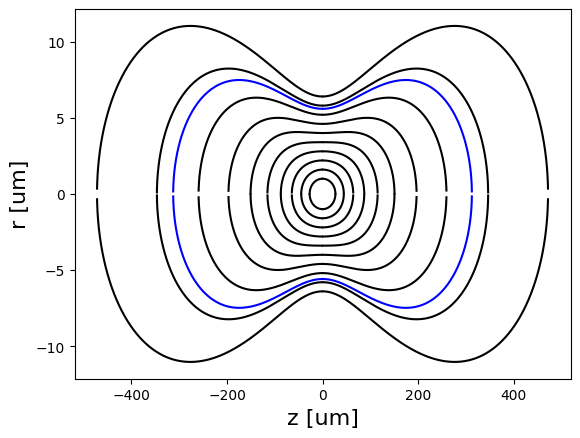

In [11]:
#M = max(wzs)
#plt.fill_between([-40, 40],[M, M],[-M, -M], alpha =0.7)

#plt.plot(zs, wzs, c="r")
#plt.plot(zs, -wzs, c="r")
#plt.plot([-z_R,z_R],[0,0], c="gray")
for r_fixedU in r_fixedUs:
    plt.plot(zs*1e6, r_fixedU*1e6, c="black")
    plt.plot(zs*1e6, -r_fixedU*1e6, c="black")
    plt.plot(-zs*1e6, r_fixedU*1e6, c="black")
    plt.plot(-zs*1e6, -r_fixedU*1e6, c="black")
plt.plot(zs*1e6, np.array(Us_T)*1e6, c="blue")
plt.plot(zs*1e6, -np.array(Us_T)*1e6, c="blue")
plt.plot(-zs*1e6, np.array(Us_T)*1e6, c="blue")
plt.plot(-zs*1e6, -np.array(Us_T)*1e6, c="blue")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()

Calculus of the blue surface
$$
A = \int_0^{z_{max}} 2 \pi r(z) dz
$$
where $U_{dip} = U_0$ is fixed and
$$
r(z) = w(z) \sqrt{\frac{1}{2} \ln \bigg(\frac{3 c^2 P \Gamma}{\omega_0^3 w(z)^2 \Delta}\frac{1}{ U_0}} \bigg)
$$

In [12]:
from scipy.integrate import quad

U0 = -scc.Boltzmann * T
def fun(x):
    return my_dip.get_inverse_U_dip(x, U0)

A = 2*quad(fun, 0, 310e-6)[0]

Plot the density coutour

In [16]:
zs = np.linspace(1e-6, 1e-3, 10000)
rs = np.linspace(1e-6, 6.4e-6, 10)

r_fixed_lds = []

for r in rs:
    d0 = my_dip.local_density(zs[0], r)
    ld_aus = []
    for z in zs:
        ld_aus.append(my_dip.get_inverse_loc_dens(z, d0))
    r_fixed_lds.append(np.array(ld_aus))

/var/folders/gq/pyfb45qx3wg52k7kygqcjy840000gn/T/ipykernel_18978/3397319961.py:56: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(-(np.log(local_density_0)+z**2/(2*self.var_z(t)))*2*self.var_r(t))


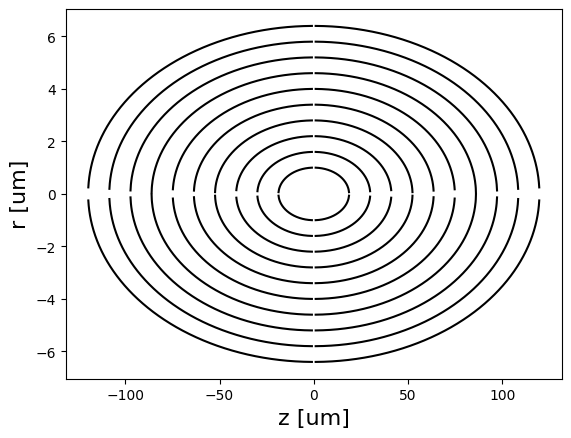

In [18]:
for r_fixed_ld in r_fixed_lds:
    plt.plot(zs*1e6, r_fixed_ld*1e6, c="black")
    plt.plot(zs*1e6, -r_fixed_ld*1e6, c="black")
    plt.plot(-zs*1e6, r_fixed_ld*1e6, c="black")
    plt.plot(-zs*1e6, -r_fixed_ld*1e6, c="black")
#plt.plot(zs*1e6, np.array(Us_T)*1e6, c="blue")
#plt.plot(zs*1e6, -np.array(Us_T)*1e6, c="blue")
#plt.plot(-zs*1e6, np.array(Us_T)*1e6, c="blue")
#plt.plot(-zs*1e6, -np.array(Us_T)*1e6, c="blue")

plt.xlabel("z [um]",fontsize=16)
plt.ylabel("r [um]",fontsize=16)

plt.show()